In [160]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


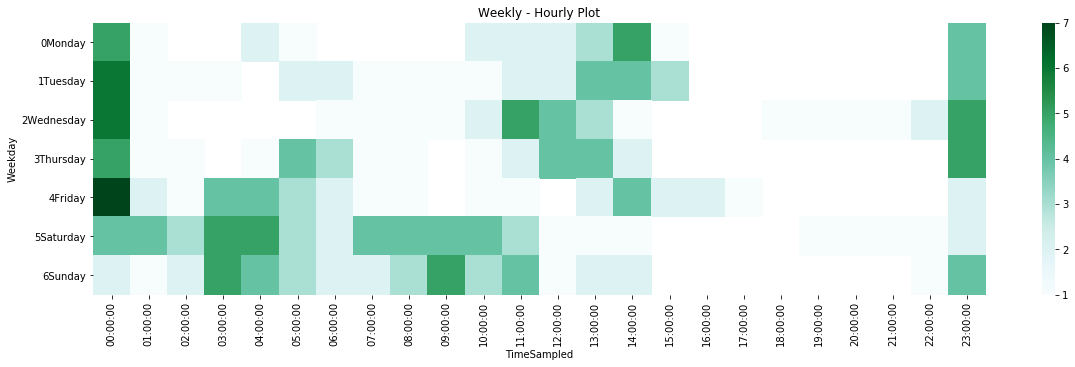

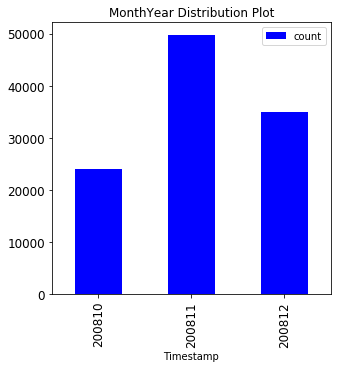

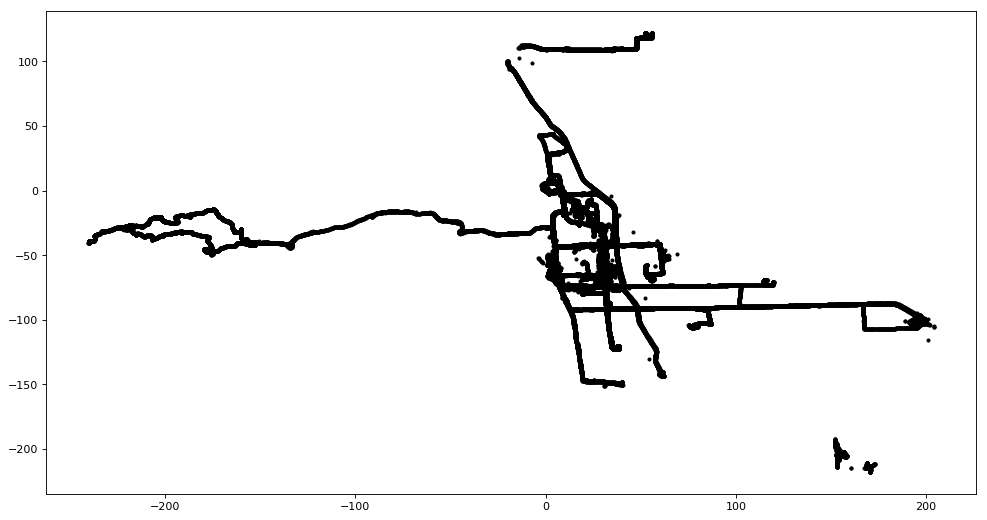

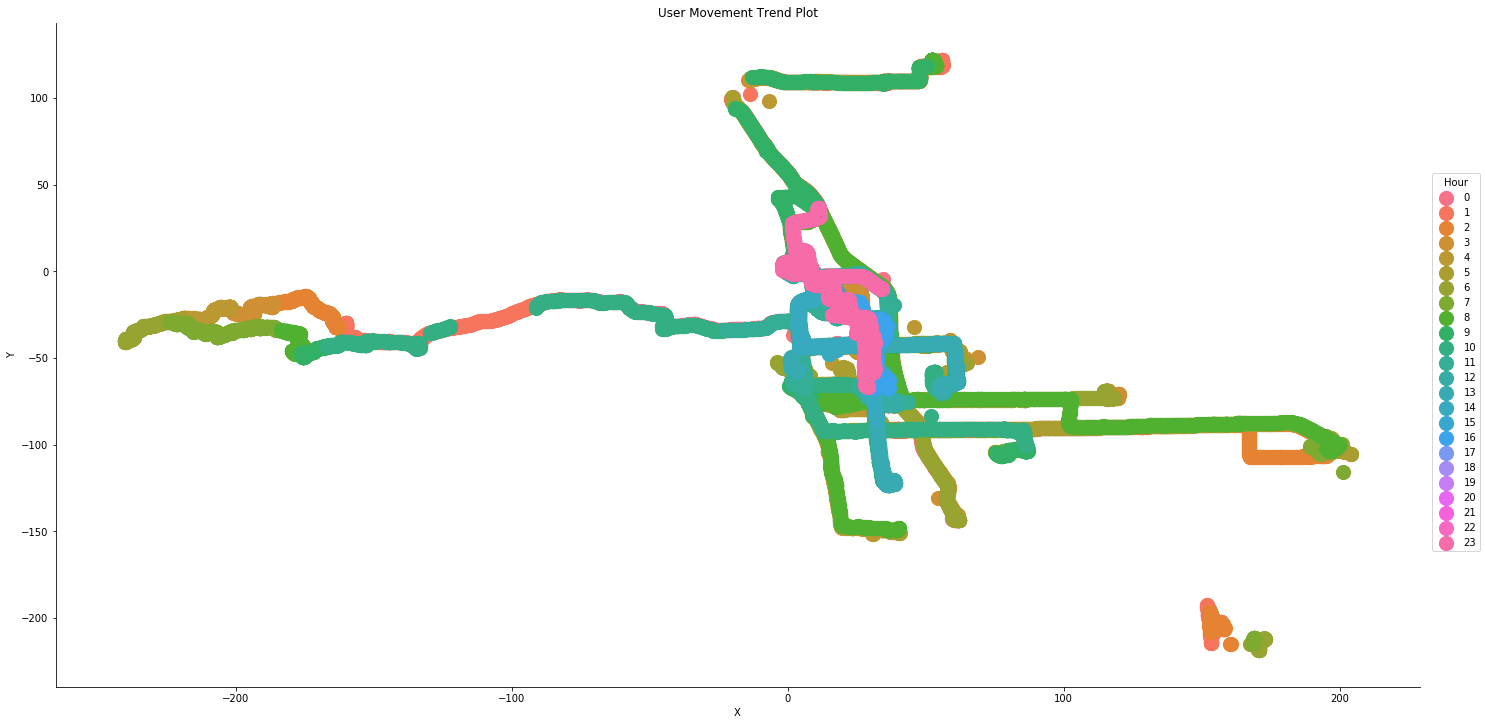

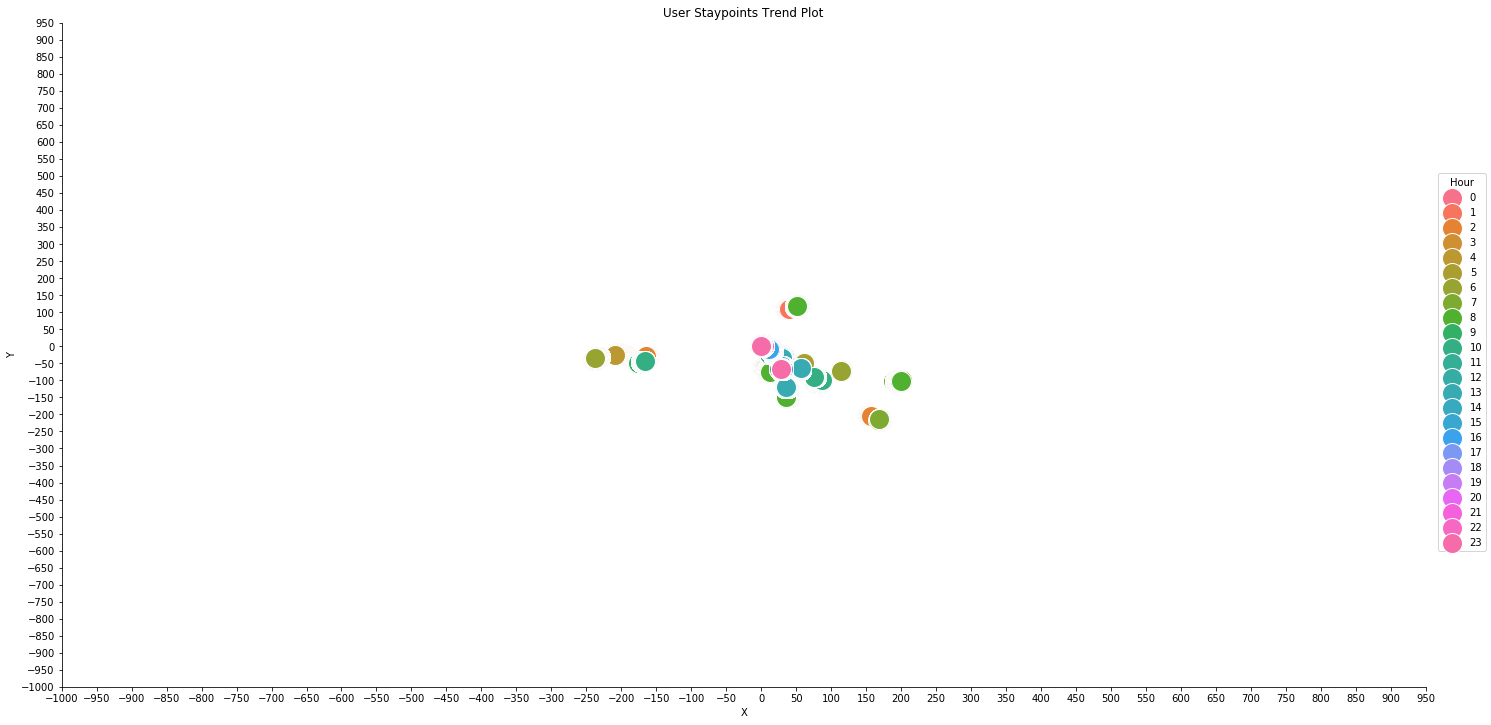

In [2]:
#Finding stay points from a user trajectory data and calculate transition matrices.
#Stay points are goverened by two parameters, time threshold and distance threshold.
#If user has spend more than threshold time(10 mins) at the same geographical location(threshold distance 50m),
# then this location is users stay point.
#This can be users home, work, a bus station or a restaurant. 
%reset

#load all the files for a user
import random
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import math 
import os
import errno
import matplotlib.patches as patches
from copy import deepcopy
from scipy.spatial.distance import cdist
from matplotlib.patches import Ellipse
import operator
import pdb
#%matplotlib nbagg

pd.options.mode.chained_assignment = None

#-----------------------------------LOAD USER FILES-----------------------------------------------------
def load_user_file():
    global combined_df
    #Load file names for user. Change here for different user replace 000 or even path as required
    filenames = glob.glob(file_source_raw)

    #Read the files
    list_of_dfs = [pd.read_csv(filename, skiprows=6, header = None) for filename in filenames]

    #put the data from list into one dataframe
    combined_df = pd.concat(list_of_dfs, ignore_index=True)

    #rename columns
    combined_df.columns = ['Latitude', 'Longitude', '0', 'Altitude', 'NumDays', 'Date', 'Time']
    combined_df['ClusterId'] = -1
    combined_df['ClusterMeanLat'] = -1.0
    combined_df['ClusterMeanLon'] = -1.0
    combined_df['StayPoint'] = -1
    combined_df['SignificantPlace'] = -1

    #add timestamp index
    combined_df["Timestamp"] = combined_df["Date"].map(str) + " " + combined_df["Time"]
    combined_df.Timestamp = pd.to_datetime(combined_df.Timestamp)
    combined_df.index = pd.to_datetime(combined_df.Timestamp)
    
    #add weekday number as column
    combined_df['Weekday'] = combined_df['Timestamp'].dt.weekday.map(str) + combined_df['Timestamp'].dt.weekday_name

    #combined_df.size
    #combined_df.head()

#-----------------------------------SAMPLE DATA PER MINUTE-----------------------------------------------------

def resample_select_data():
    global combined_df
    global sampled_df
    #Resample the data with every one minutes. Remove this if you like to process the entire file.
    #Note, it could take some time to run the further sections of the file size is very large.
    sampled_df = combined_df.copy()
    #sampled_df = combined_df.resample('1T').mean()
    #sampled_df["Timestamp"] = sampled_df.index
    #sampled_df = sampled_df.dropna()
    
    #Select the range of data you want to proceed with
    if fltr_data_date_rng == "YES":
        sampled_df = sampled_df[(sampled_df["Timestamp"] >= from_date) & (sampled_df["Timestamp"] <= to_date)]

#-----------------------------------VISUALIZE RAW DATA--------------------------------------------------------

def visualize_raw_data():
    
    if fltr_data_date_rng == "YES":
        combined_c_df = combined_df[(combined_df["Timestamp"] >= from_date) & (combined_df["Timestamp"] <= to_date)]
    else:
        combined_c_df = combined_df
        
    #Plot 1------------------
    #plot hourly vs weekly data of the user
    #Resample data on hourly basis
    hour_sampled_df = combined_c_df.resample('H').last()

    #drop column timestamp to avoid confusion as index is also timestamp
    hour_sampled_df = hour_sampled_df.drop(['Timestamp'], axis=1)

    #extract time from timestamp and add it as a column
    hour_sampled_df['TimeSampled'] = hour_sampled_df.index.time

    #form a pivot table counting number of latitudes for each weekday for each hour
    pivot_df = hour_sampled_df.pivot_table(values='Latitude', index='Weekday',columns='TimeSampled',aggfunc=len)

    #draw a plot to visualize hourly trend per weekday for the user
    fig, ax = plt.subplots(figsize=(20,5))  
    sns.heatmap(pivot_df, cmap='BuGn', ax=ax)
    plt.title('Weekly - Hourly Plot')
    plt.show()
    
    #Plot 2------------------
    #visualize counts of data for each month-year
    count_df = pd.DataFrame()
    count_df['count'] = combined_c_df.groupby(combined_c_df.index.year * 100 + combined_c_df.index.month).size() 
    count_df.plot(kind='bar', title ="V comp",figsize=(5,5),legend=True, fontsize=12, color = 'b')
    plt.title('MonthYear Distribution Plot')
    plt.show()
    
    #Plot 3------------------
    #plot raw X and Y
    
    data = sampled_df[["ClusterId", "Latitude", "Longitude", "Timestamp"]]
    data = data.reset_index(drop=True)
    
    #calculate x and y from Avg Lat and Avg Lon
    #assign the first lat and log as the base for the plot i.e. origin
    origin_lat = math.radians(data["Latitude"][0])
    origin_lon = math.radians(data["Longitude"][0])
    
    #convert each lat and lon into x and y 
    EARTH_RAD = 6378100
    data['X'] = 0.0
    data['Y'] = 0.0
    for i in range(0, len(data)):
        x = 0
        y = 0
        current_lat = math.radians(data["Latitude"][i])
        current_lon = math.radians(data["Longitude"][i])
        x = ((math.cos(current_lat) + math.cos(origin_lat))/2) * EARTH_RAD * (current_lon - origin_lon) * math.pi / 180
        y = (current_lat - origin_lat)* math.pi/180 * EARTH_RAD
        data.at[i, 'X'] = x
        data.at[i, 'Y'] = y
    
    #import pdb; pdb.set_trace()
    
    # Plotting lat and log values without clusters
    f1 = data['X'].values
    f2 = data['Y'].values
    X = np.array(list(zip(f1, f2)))
    plt.figure(figsize=(15, 8), dpi=80)
    plt.scatter(f1, f2, c='black', s=7)
    plt.show()
    
    #Plot 4------------------
    #plot to visualize the location trend of the user
    #Sample data hourly and take mean, drop nans, reset index
    
    xy_copy_df = data[['X', 'Y', 'Timestamp']].copy()
    xy_copy_df['Hour'] = xy_copy_df.Timestamp.dt.hour
    del xy_copy_df['Timestamp']
    fg = sns.FacetGrid(data=xy_copy_df, hue='Hour',  size = 10, aspect = 2)
    fg.map(plt.scatter, 'X', 'Y', s=200).add_legend()
    plt.title('User Movement Trend Plot')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    


#-----------------------------------METER DISTANCE BETWEEN TWO COORDINATES---------------------------------------

#Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):  
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c
    return d * 1000 # meters

#This function is to cluster the points together if thier distance is less than 50 meters.
#If the cluster has a total duration of 10 minutes or greater, then add it to a stay point

#-----------------------------------CLUSTER POINTS----------------------------------------------------------

def cluster(newlat, newlon, row, count):
    global sampled_df
    
    currcluster = sampled_df['ClusterId'][row-1]
    sampled_df['ClusterId'][row] = -1
    sampled_df['ClusterMeanLat'][row] = -1.0
    sampled_df['ClusterMeanLon'][row] = -1.0
    sampled_df['StayPoint'][row] = -1
    sampled_df['SignificantPlace'][row] = -1
    clulat = sampled_df['ClusterMeanLat'][row-1]
    clulon = sampled_df['ClusterMeanLon'][row-1]
    
    #import pdb; pdb.set_trace()
    if meters(clulat, clulon, newlat, newlon)<= staypts_dist:
        sampled_df['ClusterId'][row] = currcluster
        sampled_df['ClusterMeanLat'] = sampled_df.groupby('ClusterId')['Latitude'].transform(np.mean)
        sampled_df['ClusterMeanLon'] = sampled_df.groupby('ClusterId')['Longitude'].transform(np.mean)
        count = count + 1
    else:
        
        if count >= 2:
            #import pdb; pdb.set_trace()
            MinClusTime = sampled_df['Timestamp'][row-count]
            MaxClusTime = sampled_df['Timestamp'][row-1]
            k = MaxClusTime - MinClusTime
            l = (k / np.timedelta64(1, 'm')).astype(int)
            
            if (l >= staypts_time):
                sampled_df.loc[ (sampled_df['ClusterId']==currcluster), 'StayPoint'] = 1
        count = 1
        sampled_df['ClusterMeanLat'][row] = sampled_df['Latitude'][row]
        sampled_df['ClusterMeanLon'][row] = sampled_df['Longitude'][row]
        sampled_df['ClusterId'][row] = currcluster + 1
    return count

#-----------------------------------FIND STAYPOINTS USING CLUSTERS---------------------------------------------------

def find_stay_points():
    global sampled_df 
    global staypts_df
    
    sampled_df = sampled_df.sort_values(['Timestamp'])
    
    #Read the file in an online manner as the points come and assign the points to clusters
    row =1
    count = 1
    sampled_df['ClusterId'][row-1] = 0
    sampled_df['ClusterMeanLat'][row-1] = sampled_df['Latitude'][0]
    sampled_df['ClusterMeanLon'][row-1] = sampled_df['Longitude'][0]
    sampled_df['StayPoint'][row-1] = -1
    sampled_df['SignificantPlace'][row-1] = -1
    
    while row < len(sampled_df):
        count = cluster(sampled_df['Latitude'][row], sampled_df['Longitude'][row], row, count)
        row= row + 1

    #copy the stay points into another dataframe
    staypts_df = sampled_df.loc[sampled_df['StayPoint'] == 1]
    
#-----------------------------------GROUP CLUSTERS ON DIFFERENT DAYS-----------------------------------------------

def group_clusters():
    global staypts_df
    
    #this fucntion groups the clusters together from different days 
    #Copy the stay points dataframe into another dataframe and remove duplicates
    staypts_df1 = staypts_df[['ClusterId', 'ClusterMeanLat', 'ClusterMeanLon']].copy()
    staypts_df1 = staypts_df1.drop_duplicates(subset=['ClusterId', 'ClusterMeanLat', 'ClusterMeanLon'])

    staypts_df1 = staypts_df1.sort_values(['ClusterMeanLat', 'ClusterMeanLon'])

    row = 1
    for i in range(0, len(staypts_df1)):
        for j in range(i+1, len(staypts_df1)):
            #import pdb; pdb.set_trace()
        
            chk_cluster = staypts_df1['ClusterId'][i]
            chk_clulat = staypts_df1['ClusterMeanLat'][i]
            chk_clulon = staypts_df1['ClusterMeanLon'][i]
            curr_cluster = staypts_df1['ClusterId'][j]
            curr_clulat = staypts_df1['ClusterMeanLat'][j]
            curr_clulon = staypts_df1['ClusterMeanLon'][j]
        
            if meters(chk_clulat, chk_clulon, curr_clulat, curr_clulon)<= staypts_dist:
                staypts_df.loc[ (staypts_df['ClusterId']==curr_cluster), 'ClusterId'] = chk_cluster
                staypts_df['ClusterMeanLat'] = staypts_df.groupby('ClusterId')['ClusterMeanLat'].transform(np.mean)
                staypts_df['ClusterMeanLon'] = staypts_df.groupby('ClusterId')['ClusterMeanLon'].transform(np.mean)
            else:
                break

#-----------------------------------SAVE STAYPOINTS AS FILE-----------------------------------------------------

def save_file_stay_points():
    #Save the file to a location for further analysis
    staypts_df.to_csv(dest_file_staypoints, sep='\t', encoding='utf-8')

#------------------------------------VISUALIZE STAYPOINTS-------------------------------------------------------

def visualize_stay_points():
    global staypts_df
    #Plot the significant places

#     #load the staypoints file
#     staypts_df = pd.read_csv(dest_file_staypoints, sep='\t')

    #make index as datetime
    staypts_df.index = pd.to_datetime(staypts_df.Timestamp)

    #assign the first lat and log as the base for the plot i.e. origin
    origin_lat = math.radians(combined_df["Latitude"][0])
    origin_lon = math.radians(combined_df["Longitude"][0])
    staypts_df['Timestamp'] = staypts_df.index
    staypts_df = staypts_df.reset_index(drop=True)

    #convert each lat and lon into x and y for the plot w.r.t origin
    EARTH_RAD = 6378100
    staypts_df['X'] = 0.0
    staypts_df['Y'] = 0.0
    for i in range(0, len(staypts_df)):
        x = 0
        y = 0
        current_lat = math.radians(staypts_df["Latitude"][i])
        current_lon = math.radians(staypts_df["Longitude"][i])
        x = ((math.cos(current_lat) + math.cos(origin_lat))/2) * EARTH_RAD * (current_lon - origin_lon) * math.pi / 180
        y = (current_lat - origin_lat)* math.pi/180 * EARTH_RAD
        staypts_df.at[i, 'X'] = x
        staypts_df.at[i, 'Y'] = y

    #plot the x and y's
    staypts_copy_df = staypts_df[['X', 'Y', 'Timestamp']].copy()
    staypts_copy_df['Hour'] = staypts_copy_df.Timestamp.dt.hour
    del staypts_copy_df['Timestamp']
    #xy_test_df.head()
    fg = sns.FacetGrid(data=staypts_copy_df, hue='Hour',   size = 10, aspect = 2)
    fg.map(plt.scatter, 'X', 'Y', edgecolor="w", s = 400).add_legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("User Staypoints Trend Plot")
    xticks = np.arange(-1000,1000,50)
    yticks = np.arange(-1000,1000,50)
    fg.set(xticks=xticks, yticks=yticks)
    plt.show()
    
    staypts_df.index = pd.to_datetime(staypts_df.Timestamp)

#---------------------------------------------- S  T  A  R  T  -------------------------------------------------
#---------------------------------------------------------------------------------------------------
#Start of the program
                                                                                                                                                                                                                                                                                                                                                                                                        
#global dataframes used
combined_df = pd.DataFrame()
sampled_df = pd.DataFrame()
staypts_df = pd.DataFrame()
cluster_hourly_df = pd.DataFrame()
final_transition_df = pd.DataFrame()

#source, destination path and filter till date(till when the data needs to be considered). Change according to your needs
from_date = "2009-04-01 00:00:00"
to_date = "2009-04-30 23:49:00"
fltr_data_date_rng = "No"
user = "001"
staypts_dist = 200
staypts_time = 20


usr_directory = "/home/shashank/Documents/location/Data/User " + user
usr_hrly_wght_directory = "/home/shashank/Documents/location/Data/User " + user + "/hourlyweights"
usr_sty_pts_directory = "/home/shashank/Documents/location/Data/User " + user + "/staypoints"

if not os.path.exists(usr_directory):
    os.makedirs(usr_directory)
if not os.path.exists(usr_hrly_wght_directory):
    os.makedirs(usr_hrly_wght_directory)
if not os.path.exists(usr_sty_pts_directory):
    os.makedirs(usr_sty_pts_directory)    

    
file_source_raw = "/home/shashank/Documents/location/Geolife Trajectories 1.3/Data/" + user + "/Trajectory/20*.plt" 
dest_file_staypoints = usr_sty_pts_directory + "/" + from_date + "-" + to_date + ".csv"
dest_file_hourly_weights = usr_hrly_wght_directory + "/" + from_date + "-" + to_date + ".csv"
dest_path_each_day_trsn_mat = usr_hrly_wght_directory + "/"
dest_file_final_markov_chain = usr_hrly_wght_directory + "/final.csv"

#---------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------

load_user_file()

resample_select_data()

if sampled_df.empty:
    print('No data to be processed. Change user or date range and try again.')
else:
    
    visualize_raw_data()
    
    find_stay_points()
    
    if not staypts_df.empty:
        
        visualize_stay_points()
        
        save_file_stay_points()

In [4]:
staypts_df1 = staypts_df[["ClusterId", "ClusterMeanLat", "ClusterMeanLon"]].copy()
staypts_df1 = staypts_df1.drop_duplicates()
len(staypts_df1)

139

In [5]:
staypts_df1

ClusterId  ClusterMeanLat  ClusterMeanLon
Timestamp                                                     
2008-10-23 11:10:24         19       40.013782      116.306572
2008-10-24 00:10:48         32       39.978993      116.326255
2008-10-24 02:02:41         36       39.981219      116.309705
2008-10-24 03:21:33         37       39.979580      116.313453
2008-10-24 03:54:25         40       39.978708      116.326203
2008-10-24 05:38:51         44       39.981549      116.310625
2008-10-25 01:49:28         82       39.997145      116.197331
2008-10-25 03:32:39         89       40.001647      116.171749
2008-10-25 04:10:47         90       40.002088      116.167805
2008-10-25 05:24:40         95       39.996933      116.150601
2008-10-25 05:45:04         96       39.993594      116.146382
2008-10-25 08:18:39        107       39.989922      116.187247
2008-10-25 09:25:14        109       39.990632      116.192970
2008-10-25 11:18:59        139       40.013537      116.306927
2008-10-26 00:16:15        167       40.074774      116.342450
2008-10-26 03:51:05        208       39.977549      116.384096
2008-10-26 08:56:36        249       40.013844      116.306463
2008-10-27 04:49:51        270       39.978422      116.325548
2008-10-27 12:08:36        284       40.013019      116.307041
2008-10-27 23:58:02        299       39.979011      116.325809
2008-10-28 10:32:00        300       39.980621      116.327289
2008-10-28 13:37:51        314       40.013545      116.307143
2008-10-29 00:01:01        327       39.977679      116.325138
2008-10-29 11:32:17        341       40.013974      116.306409
2008-10-30 00:10:36        353       39.978922      116.326256
2008-10-30 05:30:06        357       39.981689      116.310896
2008-10-30 06:08:24        358       39.981064      116.309520
2008-10-30 06:34:50        360       39.975264      116.313031
2008-10-30 08:14:55        364       39.978481      116.327059
2008-10-30 13:41:15        377       40.013618      116.306764
...                        ...             ...             ...
2008-12-07 03:55:18       1441       40.014156      116.306253
2008-12-07 10:30:38       1455       39.998120      116.326091
2008-12-07 13:57:29       1468       40.013618      116.310717
2008-12-07 14:24:08       1469       40.013585      116.306743
2008-12-08 00:55:18       1482       39.978631      116.327049
2008-12-08 15:01:36       1495       40.013959      116.306283
2008-12-09 01:08:54       1514       39.977691      116.327457
2008-12-09 02:42:47       1572       39.977362      116.327449
2008-12-09 05:26:15       1602       39.961000      116.439279
2008-12-09 05:52:40       1605       39.961110      116.439429
2008-12-09 06:45:04       1608       39.961819      116.438588
2008-12-09 07:19:49       1611       39.960801      116.435841
2008-12-09 07:44:16       1613       39.960600      116.438379
2008-12-09 08:54:16       1641       39.977592      116.327341
2008-12-09 13:49:23       1642       39.981596      116.327302
2008-12-09 14:38:36       1657       40.015116      116.306167
2008-12-10 01:07:01       1675       39.976736      116.326989
2008-12-10 10:01:22       1693       40.015597      116.305627
2008-12-10 10:28:39       1694       40.014436      116.306234
2008-12-11 00:49:22       1711       39.979211      116.327246
2008-12-11 11:10:37       1712       39.981778      116.327687
2008-12-11 12:06:51       1727       40.013839      116.306473
2008-12-12 03:48:29       1746       39.978900      116.325770
2008-12-12 05:27:40       1758       39.974573      116.331283
2008-12-12 05:48:16       1759       39.976333      116.327732
2008-12-12 14:50:44       1774       40.013564      116.306832
2008-12-13 10:46:50       1796       39.978379      116.343692
2008-12-13 13:44:25       1815       40.013985      116.311514
2008-12-13 14:11:13       1816       40.013807      116.306506
2008-12-14 08:40:05       1829       39.978549      116.327036

[139 rows x 3 columns]